![](https://media.giphy.com/media/mIMsLsQTJzAn6/giphy.gif)

## **Introduction**

I am trying to gain experience and improve day by day in analysis and model training. This was my aim while preparing this notebook.   
What's in this notebook?
- Explorating and visualising the data with pandas and seaborn packages
- Building and tuning couple regression models to get some stable results with sklearn and Light GBM packages



### Data Set Information:

This dataset is a slightly modified version of the dataset provided in the StatLib library. In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for the "mpg" attribute. The original dataset is available in the file "auto-mpg.data-original".

### Attribute Information:

**mpg:** continuous
**cylinders:** multi-valued discrete<br>
**displacement:** continuous<br>
**horsepower:** continuous<br>
**weight:** continuous<br>
**acceleration:** continuous<br>
**model year:** multi-valued discrete<br>
**origin:** multi-valued discrete<br>
**car name:** string (unique for each instance)<br>



### So lets start..


# Lıbrary Import

In [344]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, skew

import warnings
warnings.filterwarnings("ignore")
sns.set()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autompg-dataset/auto-mpg.csv


In [345]:
train = pd.read_csv("/kaggle/input/autompg-dataset/auto-mpg.csv")

Let's look at our five random examples

In [346]:
train.sample(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
154,15.0,6,250.0,72,3432,21.0,75,1,mercury monarch
314,26.4,4,140.0,88,2870,18.1,80,1,ford fairmont
201,18.5,6,250.0,110,3645,16.2,76,1,pontiac ventura sj
114,26.0,4,98.0,90,2265,15.5,73,2,fiat 124 sport coupe
135,18.0,6,225.0,105,3613,16.5,74,1,plymouth satellite sebring


In [347]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB
None


We see that our data set consists of **398 rows and 9 columns**..

In the description of the data set, it said that the missing data is only within **hoursepower**. But when we look at the general data set, it shows **no missing data and also it shows the data type of hoursepower as object.**

The first thing that comes to my mind here is that the missing data is represented by a string "?"

In [348]:
train[train["horsepower"] == "?"]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,?,2046,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035,20.5,82,1,amc concord dl


Yes, as stated in the data set description, our missing data is 6. But we will deal with this a little later.

In [349]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


# **EDA and Feature Engineering** 

## Missing Values

As I mentioned above, I fixed the mismatch in the **"horsepower"** feature.  
 I filled the sign "?" with **np.NaN** and float the type.

In [350]:
train["horsepower"] = train["horsepower"].replace("?", np.NaN).astype("float64")

I don't want to randomly fill in missing data in Horsepower. 
So I will look at its correlation with other data in the data set.

In [351]:
train_corr=train.corr().abs().unstack().sort_values(kind = "quiksort", ascending = False).reset_index()

train_corr.rename(columns = {"level_0": "Feature A",
                            "level_1": "Feature B",
                            0:"Correlation Coefs."}, inplace = True)

train_corr[train_corr["Feature A"] == "horsepower"].style.background_gradient(cmap = "coolwarm")

,Feature A,Feature B,Correlation Coefs.
5,horsepower,horsepower,1.000000
12,horsepower,displacement,0.897257
17,horsepower,weight,0.864538
18,horsepower,cylinders,0.842983
24,horsepower,mpg,0.778427
28,horsepower,acceleration,0.689196
45,horsepower,origin,0.455171
50,horsepower,model year,0.416361


In [352]:
train.groupby(['displacement'], sort = False)["horsepower"].apply(lambda x: x.fillna(x.mean()))
train['horsepower'] = train.groupby(['cylinders'], sort=False)['horsepower'].apply(lambda x: x.fillna(x.mean()))

In [353]:
train.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

Yes, we handled the missing values!

Now I want to take a look at the distributions of numeric features.    
For this, I will divide the features into two separate groups, categoric and numeric.

In [354]:
numerical_feat = train.select_dtypes(exclude = "object")
categorical_feat = train.select_dtypes(include = "object")

print("Numeric Features are   : ", *numerical_feat)
print("Categoric Features are : ", *categorical_feat)

Numeric Features are   :  mpg cylinders displacement horsepower weight acceleration model year origin
Categoric Features are :  car name


### **Let's look at the distribution of numerical features**
- so we can see wheather feauture are skewed or not

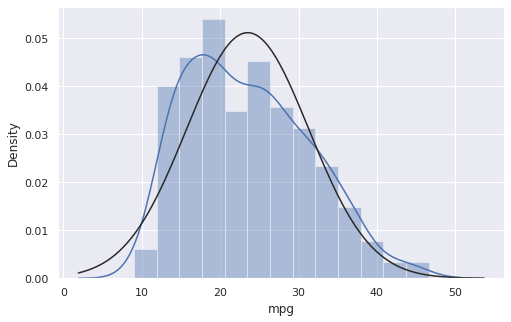

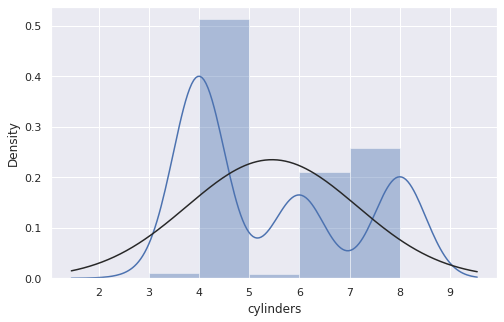

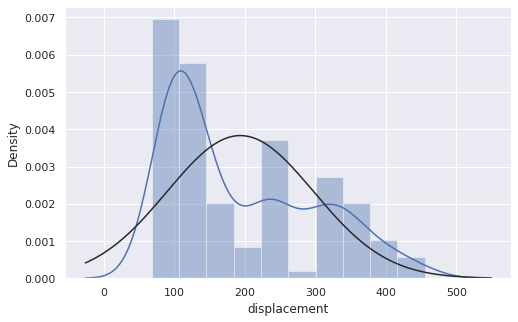

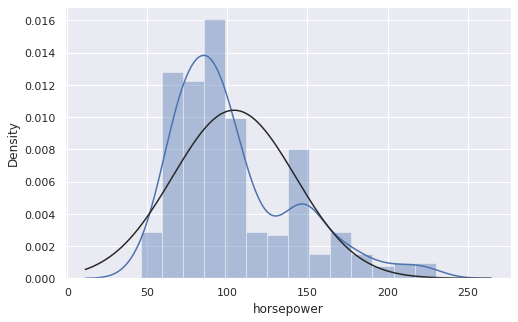

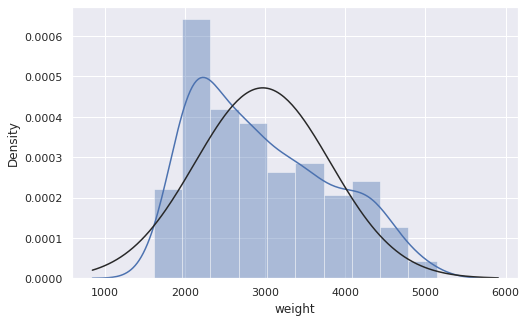

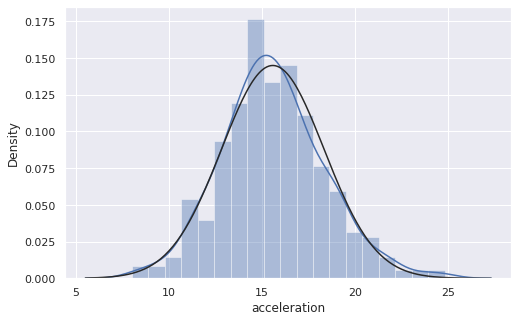

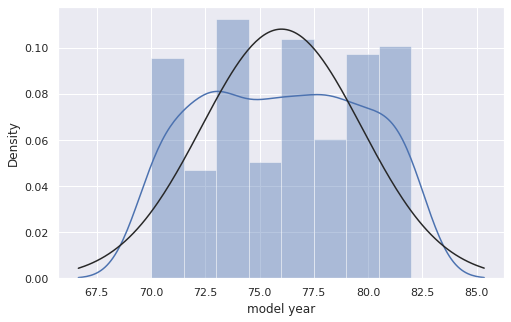

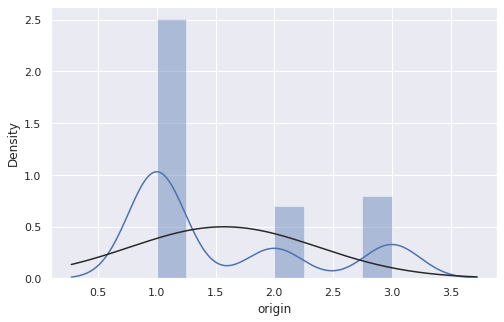

In [355]:
for column in numerical_feat.columns:
    plt.figure(figsize = (8,5))
    sns.distplot(train[column], fit = norm)
    plt.show()

- When we look at their skewness
    - We see that **Origin** and **Cylinders** are far from normal distribution. But when we look at the data set, these features are actually categorical values. That's why I'm ignoring these two.  I will change them as categoric in a soon
    - Weight, Displacement, Horsepower features has positive skew, we need deal with it
    - I'm not gonna handle "mpg" because it is target feature

Now let's change the data types of Origin and Cylinders categorically then updates the numerical_feat and categorical_feat variable with new ones

In [356]:
train["origin"] = train["origin"].astype(str)
train["cylinders"] = train["cylinders"].astype(str)

numerical_feat = train.select_dtypes(exclude = "object")
categorical_feat = train.select_dtypes(include = "object")

Now let's examine the skewness of these features numerically.

In [357]:
def checkSkewness(df):
  """
   - greater than 1 positive skewness
   - less than 1 negative skewness
  
  """
  skewed_feat = df.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
  skewness = pd.DataFrame(skewed_feat, columns = ["Skew Value"])

  return skewness.style.background_gradient(cmap='summer')

In [358]:
checkSkewness(numerical_feat)

,Skew Value
horsepower,1.104251
displacement,0.716930
weight,0.529059
mpg,0.455342
acceleration,0.277725
model year,0.011491


As can be seen from the table, I will apply **Log Transformation** to get the "Horsepower", "Displacement", "weight" features from skewness.

In [359]:
skew_feats = ["weight", "displacement","horsepower"]

train[skew_feats] = np.log1p(train[skew_feats])


# and check again
checkSkewness(train[skew_feats])

,Skew Value
horsepower,0.396553
displacement,0.228022
weight,0.155845


They are better off now

### Let's take a look at our categorical features.

In [360]:
categorical_feat.sample(5)

,cylinders,origin,car name
156,8,1,pontiac catalina
340,4,1,dodge aries wagon (sw)
312,4,3,datsun 310
376,4,3,mazda glc custom l
261,6,1,amc concord d/l


#### **Car Name**

In [361]:
train["car name"].value_counts()

ford pinto                  6
toyota corolla              5
ford maverick               5
amc matador                 5
chevrolet impala            4
                           ..
buick century luxus (sw)    1
mazda glc custom            1
cadillac eldorado           1
chevrolet woody             1
datsun 510 (sw)             1
Name: car name, Length: 305, dtype: int64

In [362]:
train = train.drop("car name", axis = 1)

I am removing this feature from the dataset because I got better results when I set up a model without it.

### **Cylinders**

In [363]:
train["cylinders"].value_counts(normalize = True)

4    0.512563
8    0.258794
6    0.211055
3    0.010050
5    0.007538
Name: cylinders, dtype: float64

Half of our data set consists of 4-cylinder vehicles

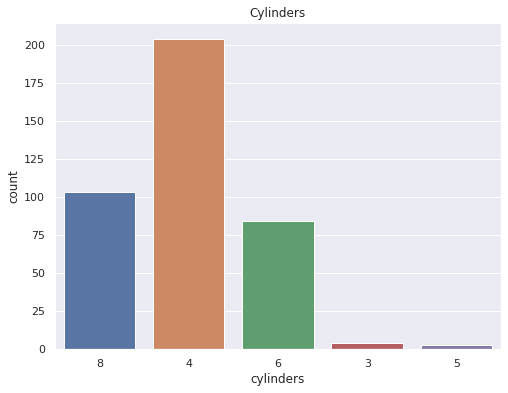

In [364]:
plt.figure(figsize = (8,6))
sns.countplot(data = train, x = "cylinders")
plt.title("Cylinders")
plt.show()

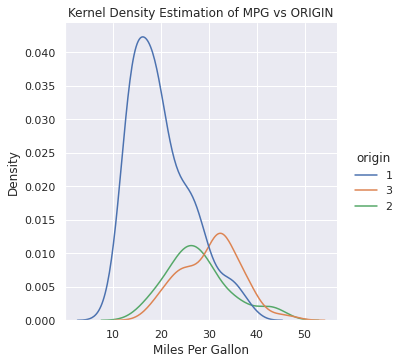

In [365]:
sns.displot(data = train, x = "mpg", hue = "origin",kind="kde");
plt.title("Kernel Density Estimation of MPG vs ORIGIN")
plt.xlabel("Miles Per Gallon")
plt.show()

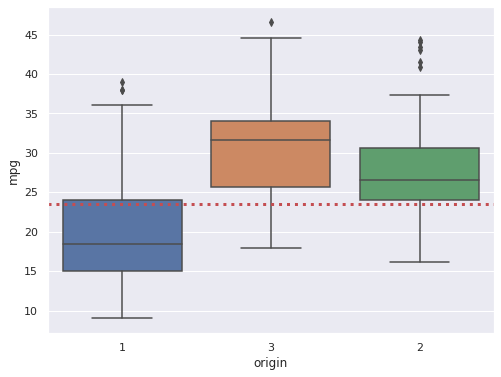

In [366]:
fig, ax = plt.subplots(figsize=(8, 6))

fig = sns.boxplot(x='origin', y="mpg", data=train)
plt.axhline(train.mpg.mean(),color='r',linestyle='dotted',linewidth=3)

plt.show()

## Correlation Matrix

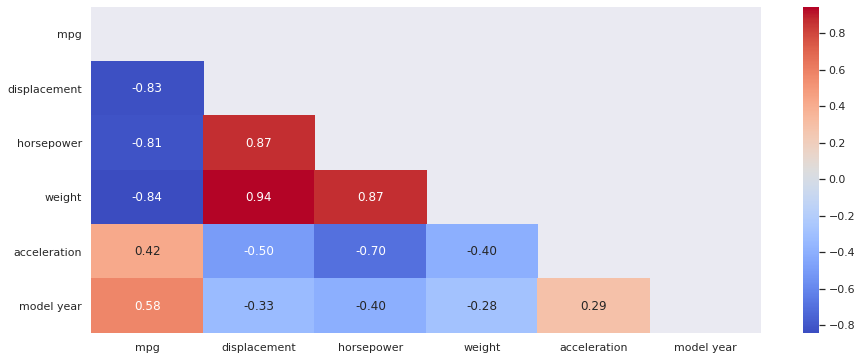

In [367]:
train_corr = train.corr()

mask = np.triu(np.ones_like(train_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(15, 6))

sns.heatmap(train_corr, annot=True,fmt='.2f',mask=mask, cmap="coolwarm", ax=ax);

There is a very high correlation between Weight and Displacement. This means that these two fefatures are almost the same.  
We can consider removing either of them from the model.

## **Label Encoding**

In [368]:
train = pd.get_dummies(train)

In [369]:
train.head(5)

,mpg,displacement,horsepower,weight,acceleration,model year,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_1,origin_2,origin_3
0,18.0,5.730100,4.875197,8.161946,12.0,70,0,0,0,0,1,1,0,0
1,15.0,5.860786,5.111988,8.214465,11.5,70,0,0,0,0,1,1,0,0
2,18.0,5.765191,5.017280,8.142354,11.0,70,0,0,0,0,1,1,0,0
3,16.0,5.720312,5.017280,8.141481,12.0,70,0,0,0,0,1,1,0,0
4,17.0,5.713733,4.948760,8.146130,10.5,70,0,0,0,0,1,1,0,0


# **Modelling**

In [370]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

import lightgbm as lgb

## **Train-Test Split**

In [371]:
x = train.drop('mpg', axis = 1)
y = train["mpg"]


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .33, random_state = 42)

## **Scaling**

In [372]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Linear Regression**

In [373]:
lr_reg = LinearRegression()

lr_reg.fit(X_train, y_train)
y_predict_reg = lr_reg.predict(X_test)

lr_rmse = np.sqrt(mean_squared_error(y_test, y_predict_reg))
lr_rmse

2.527296983729729

## **Random Forest Regressor**

In [374]:
rf_reg = RandomForestRegressor().fit(X_train, y_train)

y_pred = rf_reg.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rf_rmse

2.4686386568677516

## **Lasso**

In [375]:
lasso_reg = Lasso().fit(X_train, y_train)

y_pred = lasso_reg.predict(X_test)

lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lasso_rmse

2.671080209275271

## **ElasticNet**

In [376]:
eNet = ElasticNet().fit(X_train, y_train)

y_pred = eNet.predict(X_test)

eNet_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
eNet_rmse

2.932411978456571

## **LGBM**

In [377]:
lgb_reg = lgb.LGBMRegressor().fit(X_train, y_train)

y_pred = lgb_reg.predict(X_test)

lgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lgb_rmse

2.442059404118369

In [378]:
model_names = ["LASSO","LGBM","RANDOM FR","LINEAR","ELASTICNET"]

models = {"Model":model_names,
          "RMSE":[lasso_rmse, lgb_rmse, rf_rmse,lr_rmse,eNet_rmse]}

model_performance = pd.DataFrame(models)

model_performance.sort_values(by = "RMSE",kind='quicksort', ascending=True).style.background_gradient(cmap='summer')

,Model,RMSE
1,LGBM,2.442059
2,RANDOM FR,2.468639
3,LINEAR,2.527297
0,LASSO,2.671080
4,ELASTICNET,2.932412


These are the results we got from our basic models.


Now let's do hyperparameter optimization and see the change.

# **Hyperparameter Tunning**

## **Random Forest Regressor**

In [379]:
n_estimators = [100, 200, 500, 700]
max_depth = np.arange(10, 100, 10)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

params_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()

rf_grid_search = RandomizedSearchCV(estimator = rf, param_distributions = params_grid,
                                    n_iter = 100,scoring = "neg_root_mean_squared_error",cv = 5,
                                    n_jobs = -1, verbose = 2, refit = True).fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [380]:
y_pred = rf_grid_search.predict(X_test)

rf_tunned_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Tunned RF RMSE: ",rf_tunned_rmse )
print("Best Parameters : ",rf_grid_search.best_estimator_)

Tunned RF RMSE:  2.426070774938835
Best Parameters :  RandomForestRegressor(max_depth=80, min_samples_leaf=2, n_estimators=200)


## **LGBM**

In [381]:
lgbm_params = {"learning_rate": [0.001,0.01,0.1,1,1.5],
               "n_estimators": [300,500,700,1000],
               "max_depth": [3, 5, 8, 10],
              "num_leaves":[32,64,128],
              "min_data_in_leaf":[100,1000]}


lgbm = lgb.LGBMRegressor()

lgbm_grid_search = GridSearchCV(estimator = lgbm, param_grid = lgbm_params,
                              scoring = "neg_root_mean_squared_error",cv = 5,
                              n_jobs = -1, verbose = 2, refit = True).fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


In [382]:
y_pred = lgbm_grid_search.predict(X_test)

lgbm_tunned_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Tunned LGBM RMSE: ",lgbm_tunned_rmse )
print("Best Parameters : ",lgbm_grid_search.best_estimator_)

Tunned LGBM RMSE:  2.9518936211904583
Best Parameters :  LGBMRegressor(learning_rate=0.01, max_depth=3, min_data_in_leaf=100,
              n_estimators=1000, num_leaves=32)


## **Lasso**

In [383]:
alphas = np.logspace(-4, -0.5, 30)

tuned_params = {"alpha":alphas}

lasso = Lasso()

grid_lasso = GridSearchCV(lasso, param_grid=tuned_params,
                    cv = 5, scoring = "neg_root_mean_squared_error",
                    refit = True)
grid_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-04, 1.32035178e-04, 1.74332882e-04, 2.30180731e-04,
       3.03919538e-04, 4.01280703e-04, 5.29831691e-04, 6.99564216e-04,
       9.23670857e-04, 1.21957046e-03, 1.61026203e-03, 2.12611233e-03,
       2.80721620e-03, 3.70651291e-03, 4.89390092e-03, 6.46167079e-03,
       8.53167852e-03, 1.12648169e-02, 1.48735211e-02, 1.96382800e-02,
       2.59294380e-02, 3.42359796e-02, 4.52035366e-02, 5.96845700e-02,
       7.88046282e-02, 1.04049831e-01, 1.37382380e-01, 1.81393069e-01,
       2.39502662e-01, 3.16227766e-01])},
             scoring='neg_root_mean_squared_error')

In [384]:
y_pred = grid_lasso.predict(X_test)

lasso_tunned_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Tunned LASSO RMSE: ",lasso_tunned_rmse )
print("Best Parameters : ",grid_lasso.best_estimator_)

Tunned LASSO RMSE:  2.4993546423072908
Best Parameters :  Lasso(alpha=0.1373823795883264)


## **ElasticNet**

In [385]:
alphas = np.logspace(-4, -0.5, 30)

params_grid = {"alpha":alphas,
              "l1_ratio":np.arange(0.0,1.0,0.05)}

eNet = ElasticNet()

eNet_grid = GridSearchCV(eNet, params_grid, cv = 5,
                   scoring = "neg_root_mean_squared_error", refit = True)

eNet_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-04, 1.32035178e-04, 1.74332882e-04, 2.30180731e-04,
       3.03919538e-04, 4.01280703e-04, 5.29831691e-04, 6.99564216e-04,
       9.23670857e-04, 1.21957046e-03, 1.61026203e-03, 2.12611233e-03,
       2.80721620e-03, 3.70651291e-03, 4.89390092e-03, 6.46167079e-03,
       8.53167852e-03, 1.12648169e-02, 1.48735211e-02, 1.96382800e-02,
       2.59294380e-02, 3.42359796e-02, 4.52035366e-02, 5.96845700e-02,
       7.88046282e-02, 1.04049831e-01, 1.37382380e-01, 1.81393069e-01,
       2.39502662e-01, 3.16227766e-01]),
                         'l1_ratio': array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
             scoring='neg_root_mean_squared_error')

In [386]:
y_pred = eNet_grid.predict(X_test)

elastic_tunned_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Tunned LASSO RMSE: ",elastic_tunned_rmse )
print("Best Parameters : ",eNet_grid.best_estimator_)

Tunned LASSO RMSE:  2.50769087633036
Best Parameters :  ElasticNet(alpha=0.1373823795883264, l1_ratio=0.9500000000000001)


In [387]:
tunned_rmses = [lasso_tunned_rmse, lgbm_tunned_rmse, rf_tunned_rmse,np.NaN,elastic_tunned_rmse]

model_performance["Tunned RMSE"] = tunned_rmses

model_performance.sort_values(by = "Tunned RMSE",kind='quicksort', ascending=True).style.background_gradient(cmap='summer')


,Model,RMSE,Tunned RMSE
2,RANDOM FR,2.468639,2.426071
0,LASSO,2.671080,2.499355
4,ELASTICNET,2.932412,2.507691
1,LGBM,2.442059,2.951894
3,LINEAR,2.527297,nan


**ElasticNet** shows the biggest improvement after hyperparameter optimization. **LGBM** gives the worst performance after tuning. Sure, larger captive param_grid results could have been much different, but it's a very time-consuming process.  

As a result, Random Forest Regressor was the best algorithm in Tunned models, and LGBM was the best model in basic models.

Thank you for taking your time and reviewing so far.Please let me know if I did some mistakes, I'm still trying to improve myself! I would be very happy if you give me upvote